In [1]:
# --- Standard libraries
import os.path as osp
import heapq as hq
import matplotlib.pyplot as plt
# --- PyTorch
import torch
# --- Science python
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance, spearmanr
from utils import pred_spec, calculate_rse, bokeh_spectra
# --- Bokeh
from bokeh.io import output_notebook, show, export_png
from bokeh.layouts import row
output_notebook()
# --- XASNet
from XASNet.models import XASNet_GNN, XASNet_GAT, XASNet_GraphNet
from XASNet.utils import GraphDataProducer
from XASNet.utils.visualisation import plot_prediction
from XASNet.utils.rse import rse_predictions, rse_loss, rse_histogram

Loading BokehJS ...

In [2]:
# --- Load in the test dataset
test_dataset = torch.load('./datasets/test_mol_dataset.pt')

In [3]:
# --- Print details of the dataset
print(f'Number of graphs: {len(test_dataset)}')
print('')

# --- Print details of the first molecule/graph in the dataset
data = test_dataset[2]

print(data)
print('------------')
print(f'Molecule index: {data.idx}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 48

Data(x=[33, 17], edge_index=[2, 78], edge_attr=[78, 6], spectrum=[200], idx=[1], smiles='c12[c:4]3[c:6]4[cH:7][c:10]([C:13](=[O:30])[OH:31])[c:11]5[c:9]3[c:14]3[c:16]([cH:15][cH:12]5)[cH:17][cH:19][c:20]5[c:18]3[c:22]1[c:24]([c:23]([OH:26])[cH:21]5)[CH:25]=[CH:1][C:2]2([OH:32])[C:3](=[O:27])[C:5]=4[C:8](=[O:28])[OH:29]')
------------
Molecule index: tensor([307])
Number of nodes: 33
Number of edges: 78
Average node degree: 2.36
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [4]:
data.idx

tensor([307])

##### XASNet GNN

In [5]:
# --- Set device for model to run on
device = 'cpu'

# --- Set ML model parameters to match the loaded model
xasnet_gnn = XASNet_GNN(
    gnn_name = 'gcn', # model type
    in_channels = [17, 256, 128], # input nodes for each layer
    out_channels = [256, 128, 64], # output nodes for each layer
    num_targets = 200, # nodes for final layers
    num_layers = 3, # number of layers
    heads = 1
).to(device)

# --- Location of the ML model
path_to_model = osp.join('./best_model/xasnet_gnn_model.pt')

# --- Check if there is an existing model
if osp.exists(path_to_model):
    xasnet_gnn.load_state_dict(torch.load(path_to_model, map_location=device))
else:
    print('Model is not loaded.')

##### XASNet GAT

In [6]:
# --- Set device for model to run on
device = 'cpu'

# --- Create the type of ML model you want to run
xasnet_gat = XASNet_GAT(
    node_features_dim=17,
    in_channels=[128, 128, 128, 128],
    out_channels=[128, 128, 128, 400],
    targets=200,
    n_layers=4,
    n_heads=3,
    gat_type='gatv2_custom',
    use_residuals=True,
    use_jk=True
).to(device)

# --- Location to save model
path_to_model = osp.join('./best_model/xasnet_gat_model.pt')

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_gat.load_state_dict(torch.load(path_to_model, map_location=device))
else:
    print('Model is not loaded.')

##### XASNet GraphNet

In [7]:
# --- Set device for model to run on
device = 'cpu'

# --- Create the type of ML model you want to run
xasnet_graphnet = XASNet_GraphNet(
    node_dim=17,
    edge_dim=6,
    hidden_channels=512,
    out_channels=200,
    gat_hidd=512,
    gat_out=200,
    n_layers=3,
    n_targets=200
).to(device)

# --- Location to save model
path_to_model = osp.join('./best_model/xasnet_graphnet_model.pt')

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_graphnet.load_state_dict(torch.load(path_to_model, map_location=device))
else:
    print('Model is not loaded.')

##### View predictions

In [12]:
predict = {}
true = {}

for data in enumerate(test_dataset):
    predict[data[0]], true[data[0]] = pred_spec(xasnet_graphnet, data, test_dataset, graphnet=True)

In [13]:
wasser = []
mse = []
rse = []
spear = []

for x in range(len(predict)):
    # Wasserstein metric
    wass_temp = wasserstein_distance(true[x], predict[x])
    wasser.append(wass_temp)
    # Mean squared error
    mse_temp = mean_squared_error(true[x], predict[x])
    mse.append(mse_temp)
    # RSE
    rse_temp = calculate_rse(true[x], predict[x])
    rse.append(rse_temp)
    # Spearman coefficient
    spear_temp = spearmanr(true[x], predict[x])
    spear.append(spear_temp[0])

print(f"Average Wasserstein distance = {sum(wasser) / len(wasser)}")
print(f'Average spearman correlation coefficient = {sum(spear) / len(spear)}')
print(f"Average MSE = {sum(mse) / len(mse)}")
print(f'Average RSE = {sum(rse) / len(rse)}')

Average Wasserstein distance = 0.06666164271915964
Average spearman correlation coefficient = 0.8996004587614691
Average MSE = 0.016655645097439265
Average RSE = 0.05845466486174816


In [10]:
rank_rse = hq.nsmallest(39, rse)

rank_graph = []

for x in range(39):
    rank_idx = rse.index(rank_rse[x])
    rank_graph.append(rank_idx)

print('The 5 best RSE values are:')
for x in range(5):
    print(f'RSE = {rank_rse[x]:.4f}, graph number = {rank_graph[x]}')

print('')
print('The 5 worst RSE values are:')
for x in range(-1, -6, -1):
    print(f'RSE = {rank_rse[x]:.4f}, graph number = {rank_graph[x]}')

The 5 best RSE values are:
RSE = 0.0334, graph number = 12
RSE = 0.0335, graph number = 46
RSE = 0.0342, graph number = 42
RSE = 0.0387, graph number = 31
RSE = 0.0412, graph number = 23

The 5 worst RSE values are:
RSE = 0.0695, graph number = 26
RSE = 0.0685, graph number = 20
RSE = 0.0673, graph number = 32
RSE = 0.0663, graph number = 2
RSE = 0.0658, graph number = 38


In [11]:
# --- Plot best spectra prediction
p1 = bokeh_spectra(predict[rank_graph[0]], true[rank_graph[0]])
p2 = bokeh_spectra(predict[rank_graph[1]], true[rank_graph[1]])
p3 = bokeh_spectra(predict[rank_graph[2]], true[rank_graph[2]])
p = row(p1, p2, p3)
show(p)
#export_png(p, filename='GO_mol_best_RSE.png')

In [12]:
# --- Plot worst spectra prediction
p1 = bokeh_spectra(predict[rank_graph[-1]], true[rank_graph[-1]])
p2 = bokeh_spectra(predict[rank_graph[-2]], true[rank_graph[-2]])
p3 = bokeh_spectra(predict[rank_graph[-3]], true[rank_graph[-3]])
p = row(p1, p2, p3)
show(p)
#export_png(p, filename='GO_mol_best_RSE.png')

In [8]:
# --- Choose a molecule to predict spectra from
mol_idx = 3

# --- Set up model to predict spectra
graph_picker = GraphDataProducer(
    model=xasnet_graphnet,
    gnn_type="graphNet",
    test_data=test_dataset,
    idx_to_pick=mol_idx
)
graph = graph_picker.picked_graph

In [9]:
# --- Set variables for the spectra
y_true = graph.spectrum
# --- Predict spectrum from ML model
x_pred, y_pred = graph_picker.predictions()

Data(x=[29, 17], edge_index=[2, 76], edge_attr=[76, 6], spectrum=[200], idx=[1], smiles='C12=[C:2]3[CH:1]=[CH:23][C:22]4=[CH:21][CH:19]5[C:18]6([C:16]7([C:12]8([OH:27])[C:8]9=[C:10]([CH2:9][C:7](=[O:24])[C:6](=[C:4]19)[CH:5]1[CH:3]3[O:25]1)[CH:11]=[CH:13][CH:14]8[CH:15]=[CH:17]6)[C:20]24[O:26]7)[O:28]5', batch=[29])


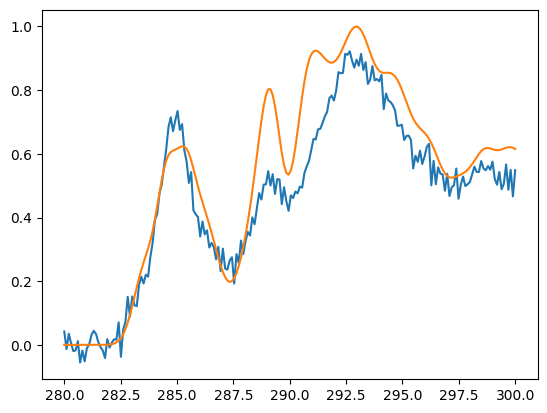

In [12]:
plt.plot(x_pred, y_pred)
plt.plot(x_pred, y_true)
plt.show()

In [ ]:
from scipy.stats import spearmanr

spear = spearmanr(y_true, y_pred)

print(spear)
print(spear[0])

SignificanceResult(statistic=0.9618420460511514, pvalue=2.091425829965994e-113)
0.9618420460511514


In [ ]:
import numpy as np

for i in range(200):
    if y_pred[i] < 0:
        y_pred[i] = 0.00000000001

sid = 0

for i in range(200):
    temp = y_pred[i] * np.log(y_pred[i]/y_true[i]) + y_true[i] * np.log(y_true[i]/y_pred[i])
    sid = sid + temp

print(sid)

tensor(1.9581, dtype=torch.float64)


In [ ]:
rse_dict = rse_predictions(xasnet_gnn, test_dataset, graphnet=False)

In [ ]:
rse_dict = {k: v.numpy() for k, v in rse_dict.items() if v < 1}

In [ ]:
rse_loss(y_pred, y_true)

tensor(0.0288, dtype=torch.float64)

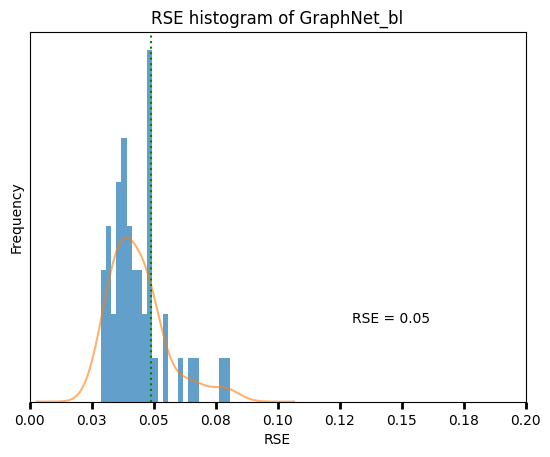

In [ ]:
rse_histogram(list(rse_dict.values()), 
              bins=25, 
              quantiles=False,
              model_name="GraphNet_bl", 
              save=False)